In [102]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import sys

In [132]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
scaler.fit(x_test)
x_test = scaler.transform(x_test)

In [104]:
x_train.shape

(404, 13)

In [161]:
class NeuralNetMLP(object):
    def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001, shuffle=True,\
        minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _relu(self,x):
        return np.clip(x,0,a_max=None)
        
    def _forward(self, X):
        """Compute forward propagation step"""
        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
        # step 2: activation of hidden layer
        a_h = self._relu(z_h)
        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
        # step 4: activation output layer
        a_out = self._relu(z_out)
        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output):
        """Compute cost function.
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
        one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
        Activation of the output layer (forward propagation)
        Returns
        ---------
        cost : float
        Regularized cost
        """
        L2_term = (self.l2 *(np.sum(self.w_h ** 2.) +np.sum(self.w_out ** 2.)))
        cost = np.linalg.norm((y_enc - output))**2 + L2_term
        return cost
    
    def predict(self, X):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
        Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
        Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        return a_out
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.
        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
        Input layer with original features.
        y_train : array, shape = [n_samples]
        Target class labels.
        X_valid : array, shape = [n_samples, n_features]
        Sample features for validation during training
        y_valid : array, shape = [n_samples]
        Sample labels for validation during training
        Returns:
        ----------
        self
        """
        n_output = 1 # no. of class labels
        n_features = X_train.shape[1]
        
        ########################
        # Weight initialization
        ########################
        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.
        n_hidden))
        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
        size=(self.n_hidden, n_output))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        # iterate over training epochs
        for i in range(self.epochs):
        # iterate over minibatch
            indices = np.arange(X_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0] -self.minibatch_size +1, self.minibatch_size):
                batch_idx = indices\
                [start_idx:start_idx+self.minibatch_size]
                # forward propagation
                z_h, a_h, z_out, a_out = \
                self._forward(X_train[batch_idx])
        
                ##################
                # Backpropagation
                ##################
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train[batch_idx]
                # [n_samples, n_hidden]
                relu_derivative_h =np.zeros(len(a_h[0]))
                for i in range(len(a_h[0])):
                    if a_h[0][i] > 0:
                        relu_derivative_h[i] = 1
                    else:
                        relu_derivative_h[i] = 0
                # [n_samples, n_classlabels] dot
                # [n_classlabels, # n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) * \
                relu_derivative_h)
                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
            
                # Evaluation
                #############
                # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_train ,a_out)
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            train_acc = ((np.sum(y_train == \
            y_train_pred)).astype(np.float) /
            X_train.shape[0])
            valid_acc = ((np.sum(y_valid ==\
            y_valid_pred)).astype(np.float) /
            X_valid.shape[0])
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self

In [162]:
mlp = NeuralNetMLP()
mlp.n_hidden=3

In [163]:
mlp.fit(x_train, y_train, x_test, y_test)

In [164]:
y_pred = mlp.predict(x_test)[:,0]
y_pred[:10]

array([ 7.72284164, 17.16627345, 21.67759405, 37.70201651, 24.18356276,
       19.28246978, 28.08173828, 23.51688437, 16.17312442, 18.81618539])

In [165]:
y_test[:10]

array([ 7.2, 18.8, 19. , 27. , 22.2, 24.5, 31.2, 22.9, 20.5, 23.2])

In [166]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

24.97754178862444

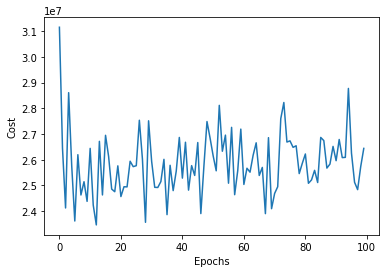

In [167]:
plt.plot(range(mlp.epochs), mlp.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

(404,)


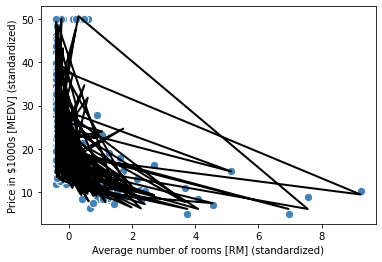

In [178]:
def lin_regplot(X, y, model):
    plt.scatter(X[:,0], y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X[:,0], model.predict(X), color='black', lw=2)
    return None
print(x_train[:,0].shape)
lin_regplot(x_train, y_train, mlp)
plt.show()

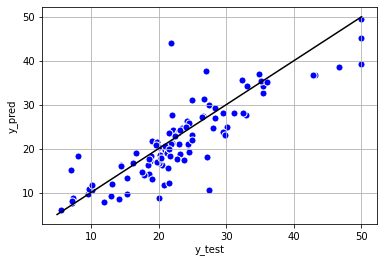

In [190]:
x = np.linspace(5,50,1000)
plt.scatter(y_test, y_pred, c='b',edgecolor='white',s=50)
plt.ylabel('y_pred')
plt.xlabel('y_test')
plt.plot(x,x,c='black')
plt.grid()